# Word Level Federated Text Generation with Stack Overflow with Randomly Initialized or Pretrained Word Embeddings
- 03-05-20
- Runs on GCP and local Ubuntu 16.04

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).  The embedding layer is initialized with one of the following options by setting the `EMBEDDING_LAYER` parameter:
- [GloVe](https://nlp.stanford.edu/projects/glove/) ([license here](https://www.opendatacommons.org/licenses/pddl/1.0/))
- [FastText](https://fasttext.cc/docs/en/english-vectors.html) ([license here](https://creativecommons.org/licenses/by-sa/3.0/))
- [GPT-2](https://openai.com/blog/better-language-models/) ([license here](https://github.com/huggingface/transformers/blob/master/LICENSE))
- [Randomly initialized embeddings](https://www.tensorflow.org/api_docs/python/tf/random_uniform_initializer)  

After downloading the GloVe or FastText embeddings, place the embedding files at the top level of the repository in directories called `word_embedding/glove` and `word_embedding/fasttext` respectively.  GPT-2 embeddings are downloaded by running the notebook which makes a call to `src/embeddings.py` to download the embeddings from [huggingface](https://github.com/huggingface/transformers).  

**Code from Tensorflow Federated:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data and Model References:**
- [TFF Stack Overflow `load_data`](https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data)
- [TFF text generation tutorial](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb)
- [Google TFF team research baselines for Stack Overflow](https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow)
- [Tensorflow text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation)

**Environment Setup References:**
- [Installing Tensorflow for GPU](https://www.tensorflow.org/install/gpu)
- [Install CUDA 10.0 and cuDNN v7.4.2 on Ubuntu 16.04](https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d)
- [Tensorflow build configs](https://www.tensorflow.org/install/source#tested_build_configurations)
- [Using jupyter notebooks with a virtual environment](https://anbasile.github.io/programming/2017/06/25/jupyter-venv/)

### Imports

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
import collections
import functools
import six
import time
import string
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_federated as tff

In [4]:
from src import dataset, metrics, embeddings, model, validation, federated, generate_text, transfer_learning

### Set Some Parameters for Preprocessing the Data and Training the Model

In [5]:
VOCAB_SIZE = 10000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 20000
NUM_TEST_EXAMPLES = 100

PRETRAINING_ROUNDS = 30
NUM_ROUNDS = 100
NUM_TRAIN_CLIENTS = 10

EMBEDDING_DIM = 50
RNN_UNITS = 128

EMBEDDING_LAYER = 'pp_pca_pp_gpt2'
SAV = 'embedding_layer_results/pretrainedNet_{}_{}_{}_{}/'.format(EMBEDDING_LAYER, 
                                                    EMBEDDING_DIM, 
                                                    RNN_UNITS, 
                                                    EMBEDDING_DIM)

### Create the Output Directory if Nonexistent

In [6]:
if not os.path.exists(SAV):
    os.makedirs(SAV)

### Load and Preprocess Word Level Datasets

In [7]:
train_data, val_data, test_data = dataset.construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Retrieve the Fine Tunining Dataset Vocab

In [8]:
vocab = dataset.get_vocab(vocab_size=VOCAB_SIZE)

### Pretrain with a Different Text Corpus by First Reading in the Text Data

In [9]:
with open('../../raw_shakespeare_data.txt') as f:
    data = f.read()

### Create the Pretraining Dataset Vocab

In [10]:
word_counts_sp = {}
for word in data.split():
    word_counts_sp[word] = word_counts_sp.get(word, 0) + 1

In [11]:
sorted_word_counts_sp = {k: v for k, v in sorted(word_counts_sp.items(),
                         key=lambda item: item[1], reverse=True)}

In [12]:
vocab_sp = list(sorted_word_counts_sp.keys())[:VOCAB_SIZE]

In [13]:
pad, oov, bos, eos = dataset.get_special_token_words()
extended_vocab = [pad] + vocab_sp + [oov, bos, eos]
word2idx = {word: i for i, word in enumerate(extended_vocab)}

In [14]:
extended_vocab_size = len(extended_vocab)

### Encode Words in the Training Dataset

In [15]:
encoded = []
for word in data.split():
    if not word2idx.get(word, None): # return None if not found
        encoded.append(0) # 0 is the pad token
    else:
        encoded.append(word2idx[word])

In [16]:
X, Y = [], []
for i in range(len(encoded)-1):
    X.append(encoded[i])
    Y.append(encoded[i + 1])

In [17]:
X = np.expand_dims(X, 1)
Y = np.expand_dims(Y, 1)

### Build the Embedding Matrix

In [18]:
word2embedding = embeddings.create_gpt_embeddings(vocab_sp)
word2embedding = embeddings.to_pp_pca_pp_projections(word2embedding, vocab_sp, EMBEDDING_DIM)
embedding_matrix = embeddings.create_matrix_from_pretrained_embeddings(
        word2embedding=word2embedding,
        embedding_dim=EMBEDDING_DIM,
        vocab=vocab_sp)

/home/joel_stremmel/Documents/dev_gear/git/fl-text-models/src/embeddings.py:80: missing_words_warning: 4 words set to default random initialization
  .format(missing), missing_words_warning)


### Build the Model

In [19]:
keras_model_sp = model.build_model(extended_vocab_size=extended_vocab_size,
                                   embedding_dim=EMBEDDING_DIM,
                                   embedding_matrix=embedding_matrix,
                                   rnn_units=RNN_UNITS)

### Compile the Model

In [20]:
evaluation_metrics_sp = validation.get_metrics(VOCAB_SIZE)
model.compile_model(keras_model_sp, evaluation_metrics_sp)

In [21]:
keras_model_sp.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model1_input (InputLayer)    [(None, None)]            0         
_________________________________________________________________
model1_embedding (Embedding) (None, None, 50)          500200    
_________________________________________________________________
model1_lstm (LSTM)           (None, None, 128)         91648     
_________________________________________________________________
dense (Dense)                (None, None, 50)          6450      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10004)       510204    
Total params: 1,108,502
Trainable params: 1,108,502
Non-trainable params: 0
_________________________________________________________________


### Train the Model

In [22]:
history = keras_model_sp.fit(X, Y, epochs=PRETRAINING_ROUNDS)

Train on 904064 samples
Epoch 1/30
904064/904064 [==============================] - 202s 223us/sample - loss: 5.1688 - num_tokens: 705808.0000 - num_tokens_no_oov: 705808.0000 - num_batches: 28252.0000 - num_examples: 904064.0000 - accuracy: 0.0632 - accuracy_no_oov: 0.0632 - accuracy_no_oov_no_eos: 0.0632
Epoch 2/30
904064/904064 [==============================] - 200s 221us/sample - loss: 4.8208 - num_tokens: 705808.0000 - num_tokens_no_oov: 705808.0000 - num_batches: 28252.0000 - num_examples: 904064.0000 - accuracy: 0.0878 - accuracy_no_oov: 0.0878 - accuracy_no_oov_no_eos: 0.0878
Epoch 3/30
904064/904064 [==============================] - 200s 221us/sample - loss: 4.7419 - num_tokens: 705808.0000 - num_tokens_no_oov: 705808.0000 - num_batches: 28252.0000 - num_examples: 904064.0000 - accuracy: 0.0916 - accuracy_no_oov: 0.0916 - accuracy_no_oov_no_eos: 0.0916
Epoch 4/30
904064/904064 [==============================] - 200s 221us/sample - loss: 4.6923 - num_tokens: 705808.0000 - num

904064/904064 [==============================] - 199s 220us/sample - loss: 4.4943 - num_tokens: 705808.0000 - num_tokens_no_oov: 705808.0000 - num_batches: 28252.0000 - num_examples: 904064.0000 - accuracy: 0.0954 - accuracy_no_oov: 0.0954 - accuracy_no_oov_no_eos: 0.0954
Epoch 30/30
904064/904064 [==============================] - 199s 220us/sample - loss: 4.4928 - num_tokens: 705808.0000 - num_tokens_no_oov: 705808.0000 - num_batches: 28252.0000 - num_examples: 904064.0000 - accuracy: 0.0955 - accuracy_no_oov: 0.0955 - accuracy_no_oov_no_eos: 0.0955


### Create Embedding Matrix from Words in Word Index and Word Embeddings
If the `EMBEDDING_LAYER` option is set to 'random', the embedding matrix in the embedding layer is initialized according to the random uniform distribution used by the tf.keras embedding layer by passing the 'uniform' string as an argument to the `embedding_initializer` in the `build_model` function.  Otherwise, an embedding index called `word2embedding` is created from pretrained embeddings either loaded from the 'word_embeddings' directory or created from a pretrained model.

In [23]:
if EMBEDDING_LAYER == 'random':
    pass

elif EMBEDDING_LAYER == 'glove':
    embedding_path = '../word_embeddings/glove/glove.6B.{}d.txt'.format(EMBEDDING_DIM)
    word2embedding = embeddings.load_embeddings(embedding_path)
    
elif EMBEDDING_LAYER == 'fasttext':
    embedding_path = '../word_embeddings/fasttext/wiki-news-300d-1M.vec'
    word2embedding = embeddings.load_embeddings(embedding_path)
    
elif EMBEDDING_LAYER == 'pca_fasttext':
    embedding_path = '../word_embeddings/fasttext/wiki-news-300d-1M.vec'
    word2embedding = embeddings.load_embeddings(embedding_path)
    word2embedding = embeddings.to_pca_projections(word2embedding, vocab, EMBEDDING_DIM)

elif EMBEDDING_LAYER == 'pp_pca_pp_fasttext':
    embedding_path = '../word_embeddings/fasttext/wiki-news-300d-1M.vec'
    word2embedding = embeddings.load_embeddings(embedding_path)
    word2embedding = embeddings.to_pp_pca_pp_projections(word2embedding, vocab, EMBEDDING_DIM)
    
elif EMBEDDING_LAYER == 'gpt2':
    word2embedding = embeddings.create_gpt_embeddings(vocab)
    word2embedding = embeddings.to_pca_projections(word2embedding, vocab, EMBEDDING_DIM)

elif EMBEDDING_LAYER == 'pca_gpt2':
    word2embedding = embeddings.create_gpt_embeddings(vocab)
    word2embedding = embeddings.to_pca_projections(word2embedding, vocab, EMBEDDING_DIM)

elif EMBEDDING_LAYER == 'pp_pca_pp_gpt2':
    word2embedding = embeddings.create_gpt_embeddings(vocab)
    word2embedding = embeddings.to_pp_pca_pp_projections(word2embedding, vocab, EMBEDDING_DIM)
    
else:
    layer_opts = ['random', 'glove',
                  'fasttext', 'pca_fasttext', 'pp_pca_pp_fasttext', 
                  'gpt2', 'pca_gpt2', 'pp_pca_pp_gpt2']
    
    raise ValueError("EMBEDDING LAYER must be in {}.".format(layer_opts))

In [24]:
if EMBEDDING_LAYER == 'random':
    embedding_matrix = 'uniform'
else:
    embedding_matrix = embeddings.create_matrix_from_pretrained_embeddings(
        word2embedding=word2embedding,
        embedding_dim=EMBEDDING_DIM,
        vocab=vocab)

/home/joel_stremmel/Documents/dev_gear/git/fl-text-models/src/embeddings.py:80: missing_words_warning: 5 words set to default random initialization
  .format(missing), missing_words_warning)


### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [25]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Initialize Train and Validation Model Trackers to be Used Below

In [26]:
PRETRAINING_ROUNDSevaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)
val_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)

### Create an Iterative Process

In [27]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=lambda : model.model_fn(extended_vocab_size=extended_vocab_size,
                                           embedding_dim=EMBEDDING_DIM,
                                           embedding_matrix=embedding_matrix,
                                           rnn_units=RNN_UNITS,
                                           vocab_size=VOCAB_SIZE,
                                           sample_batch=sample_batch),
          server_optimizer_fn=federated.server_optimizer_fn,
          client_weight_fn=federated.client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/learning/federated_averaging.py:242: UserWarning: tff.learning.build_federated_averaging_process will start requiring a new argument 'client_optimizer_fn'. Specify the local client optimizer here rather than building a ttf.learning.TrainableModel
  warnings.warn('tff.learning.build_federated_averaging_process will start '


### Following is the step where the transfer learning actually takes place

In [28]:
server_state = transfer_learning.learn_from_pretrained_model(iterative_process, keras_model_sp)

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

In [29]:
start_time = time.time()
for round_num in tqdm(range(0, NUM_ROUNDS)):

    # Examine validation metrics
    print('Evaluating before round #{} on {} examples.'.format(round_num, NUM_VALIDATION_EXAMPLES))
    validation.keras_evaluate(state=server_state,
                              val_dataset=val_data,
                              extended_vocab_size=extended_vocab_size,
                              vocab_size=VOCAB_SIZE,
                              embedding_dim=EMBEDDING_DIM,
                              embedding_matrix=embedding_matrix,
                              rnn_units=RNN_UNITS,
                              metrics_tracker=val_metrics_tracker,
                              checkpoint_dir=SAV)

    # Sample train clients to create a train dataset
    print('\nSampling {} new clients.'.format(NUM_TRAIN_CLIENTS))
    train_clients = federated.get_sample_clients(dataset=train_data, num_clients=NUM_TRAIN_CLIENTS)
    train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

    # Apply federated training round
    server_state, server_metrics = iterative_process.next(server_state, train_datasets)

    # Examine training metrics
    print('Round: {}'.format(round_num))
    print('   Loss: {:.8f}'.format(server_metrics.loss))
    print('   num_batches: {}'.format(server_metrics.num_batches))
    print('   num_examples: {}'.format(server_metrics.num_examples))
    print('   num_tokens: {}'.format(server_metrics.num_tokens))
    print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
    print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
    print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

    # Add train metrics to tracker
    train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
    train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
    train_metrics_tracker.add_metrics_by_name('num_examples', server_metrics.num_examples)
    train_metrics_tracker.add_metrics_by_name('num_tokens', server_metrics.num_tokens)
    train_metrics_tracker.add_metrics_by_name('num_tokens_no_oov', server_metrics.num_tokens_no_oov)
        
    # Save loss and accuracy from train and validation sets
    np.save(SAV + 'train_loss.npy', train_metrics_tracker.get_metrics_by_name('loss'))
    np.save(SAV + 'val_loss.npy', val_metrics_tracker.get_metrics_by_name('loss'))
    np.save(SAV + 'train_accuracy.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
    np.save(SAV + 'val_accuracy.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))
        
    # Save train sample stats
    np.save(SAV + 'num_examples.npy', train_metrics_tracker.get_metrics_by_name('num_examples'))
    np.save(SAV + 'num_tokens.npy', train_metrics_tracker.get_metrics_by_name('num_tokens'))
    np.save(SAV + 'num_tokens_no_oov.npy', train_metrics_tracker.get_metrics_by_name('num_tokens_no_oov'))
    
    # Write time since start of training
    with open(SAV + 'train_time.txt', 'a+') as f: 
        f.write('{}\n'.format(time.time() - start_time))

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating before round #0 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 105ms/step - loss: 6.7645 - num_tokens: 259111.0000 - num_tokens_no_oov: 251670.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0091 - accuracy_no_oov: 0.0094 - accuracy_no_oov_no_eos: 0.0100
Saving model weights at iteration: 0

Sampling 10 new clients.


  1%|          | 1/100 [00:38<1:03:31, 38.49s/it]

Round: 0
   Loss: 7.15256023
   num_batches: 114
   num_examples: 1741
   num_tokens: 22178
   num_tokens_no_oov: 21641
   accuracy: 0.00785
   accuracy_no_oov: 0.00804
Evaluating before round #1 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 104ms/step - loss: 7.0083 - num_tokens: 269582.0000 - num_tokens_no_oov: 260515.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0117 - accuracy_no_oov: 0.0121 - accuracy_no_oov_no_eos: 0.0128
Saving model weights at iteration: 1

Sampling 10 new clients.


  2%|▏         | 2/100 [01:19<1:04:01, 39.19s/it]

Round: 1
   Loss: 6.52711296
   num_batches: 247
   num_examples: 3877
   num_tokens: 49845
   num_tokens_no_oov: 48362
   accuracy: 0.00662
   accuracy_no_oov: 0.00682
Evaluating before round #2 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 107ms/step - loss: 6.7871 - num_tokens: 265322.0000 - num_tokens_no_oov: 256916.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0096 - accuracy_no_oov: 0.0099 - accuracy_no_oov_no_eos: 0.0105
Sampling 10 new clients.


  3%|▎         | 3/100 [02:01<1:04:51, 40.12s/it]

Round: 2
   Loss: 6.19001675
   num_batches: 262
   num_examples: 4109
   num_tokens: 50445
   num_tokens_no_oov: 48953
   accuracy: 0.00624
   accuracy_no_oov: 0.00643
Evaluating before round #3 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 106ms/step - loss: 6.8128 - num_tokens: 269299.0000 - num_tokens_no_oov: 260399.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0100 - accuracy_no_oov: 0.0103 - accuracy_no_oov_no_eos: 0.0110
Sampling 10 new clients.


  4%|▍         | 4/100 [02:43<1:05:14, 40.78s/it]

Round: 3
   Loss: 6.38998747
   num_batches: 229
   num_examples: 3628
   num_tokens: 51195
   num_tokens_no_oov: 50041
   accuracy: 0.01768
   accuracy_no_oov: 0.01809
Evaluating before round #4 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 6.4975 - num_tokens: 259046.0000 - num_tokens_no_oov: 251498.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0098 - accuracy_no_oov: 0.0101 - accuracy_no_oov_no_eos: 0.0107
Sampling 10 new clients.


  5%|▌         | 5/100 [03:26<1:05:25, 41.32s/it]

Round: 4
   Loss: 5.95452166
   num_batches: 243
   num_examples: 3792
   num_tokens: 49267
   num_tokens_no_oov: 47864
   accuracy: 0.02172
   accuracy_no_oov: 0.02236
Evaluating before round #5 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 104ms/step - loss: 7.0192 - num_tokens: 289238.0000 - num_tokens_no_oov: 280821.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0103 - accuracy_no_oov: 0.0106 - accuracy_no_oov_no_eos: 0.0111
Sampling 10 new clients.


  6%|▌         | 6/100 [04:03<1:02:40, 40.01s/it]

Round: 5
   Loss: 6.94250202
   num_batches: 79
   num_examples: 1195
   num_tokens: 15727
   num_tokens_no_oov: 15335
   accuracy: 0.00744
   accuracy_no_oov: 0.00763
Evaluating before round #6 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 23s 113ms/step - loss: 6.5934 - num_tokens: 266662.0000 - num_tokens_no_oov: 257783.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0096 - accuracy_no_oov: 0.0099 - accuracy_no_oov_no_eos: 0.0105
Sampling 10 new clients.


  7%|▋         | 7/100 [04:46<1:03:13, 40.79s/it]

Round: 6
   Loss: 6.11757183
   num_batches: 259
   num_examples: 4071
   num_tokens: 52517
   num_tokens_no_oov: 51180
   accuracy: 0.00697
   accuracy_no_oov: 0.00715
Evaluating before round #7 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 6.5366 - num_tokens: 267684.0000 - num_tokens_no_oov: 259920.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0095 - accuracy_no_oov: 0.0097 - accuracy_no_oov_no_eos: 0.0103
Sampling 10 new clients.


  8%|▊         | 8/100 [05:37<1:07:38, 44.11s/it]

Round: 7
   Loss: 3.90115666
   num_batches: 537
   num_examples: 8520
   num_tokens: 85803
   num_tokens_no_oov: 83200
   accuracy: 0.07353
   accuracy_no_oov: 0.07548
Evaluating before round #8 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 108ms/step - loss: 6.4978 - num_tokens: 268007.0000 - num_tokens_no_oov: 260045.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0093 - accuracy_no_oov: 0.0095 - accuracy_no_oov_no_eos: 0.0101
Sampling 10 new clients.


  9%|▉         | 9/100 [06:27<1:09:27, 45.80s/it]

Round: 8
   Loss: 5.26324892
   num_batches: 459
   num_examples: 7271
   num_tokens: 99968
   num_tokens_no_oov: 96865
   accuracy: 0.06260
   accuracy_no_oov: 0.06286
Evaluating before round #9 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 23s 114ms/step - loss: 6.4268 - num_tokens: 265600.0000 - num_tokens_no_oov: 257214.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0092 - accuracy_no_oov: 0.0095 - accuracy_no_oov_no_eos: 0.0101
Sampling 10 new clients.


 10%|█         | 10/100 [07:13<1:08:31, 45.68s/it]

Round: 9
   Loss: 6.05551338
   num_batches: 326
   num_examples: 5138
   num_tokens: 71968
   num_tokens_no_oov: 70053
   accuracy: 0.01127
   accuracy_no_oov: 0.01158
Evaluating before round #10 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 107ms/step - loss: 6.5358 - num_tokens: 274206.0000 - num_tokens_no_oov: 265440.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0104 - accuracy_no_oov: 0.0107 - accuracy_no_oov_no_eos: 0.0113
Sampling 10 new clients.


 11%|█         | 11/100 [07:53<1:05:28, 44.14s/it]

Round: 10
   Loss: 5.83645439
   num_batches: 213
   num_examples: 3320
   num_tokens: 40948
   num_tokens_no_oov: 39861
   accuracy: 0.00535
   accuracy_no_oov: 0.00549
Evaluating before round #11 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 106ms/step - loss: 6.3014 - num_tokens: 265679.0000 - num_tokens_no_oov: 256478.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0099 - accuracy_no_oov: 0.0102 - accuracy_no_oov_no_eos: 0.0108
Sampling 10 new clients.


 12%|█▏        | 12/100 [08:38<1:04:56, 44.27s/it]

Round: 11
   Loss: 5.84565496
   num_batches: 342
   num_examples: 5374
   num_tokens: 72703
   num_tokens_no_oov: 70050
   accuracy: 0.01752
   accuracy_no_oov: 0.01812
Evaluating before round #12 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 110ms/step - loss: 6.1910 - num_tokens: 262423.0000 - num_tokens_no_oov: 254473.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0053 - accuracy_no_oov: 0.0054 - accuracy_no_oov_no_eos: 0.0058
Sampling 10 new clients.


 13%|█▎        | 13/100 [09:21<1:03:37, 43.88s/it]

Round: 12
   Loss: 5.68998480
   num_batches: 248
   num_examples: 3891
   num_tokens: 49843
   num_tokens_no_oov: 48414
   accuracy: 0.00921
   accuracy_no_oov: 0.00948
Evaluating before round #13 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 110ms/step - loss: 6.2382 - num_tokens: 265421.0000 - num_tokens_no_oov: 256730.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0050 - accuracy_no_oov: 0.0051 - accuracy_no_oov_no_eos: 0.0054
Sampling 10 new clients.


 14%|█▍        | 14/100 [10:10<1:05:07, 45.43s/it]

Round: 13
   Loss: 4.92299128
   num_batches: 446
   num_examples: 7051
   num_tokens: 94421
   num_tokens_no_oov: 91754
   accuracy: 0.05520
   accuracy_no_oov: 0.05610
Evaluating before round #14 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 6.3038 - num_tokens: 271728.0000 - num_tokens_no_oov: 263428.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0053 - accuracy_no_oov: 0.0055 - accuracy_no_oov_no_eos: 0.0058
Sampling 10 new clients.


 15%|█▌        | 15/100 [10:51<1:02:38, 44.22s/it]

Round: 14
   Loss: 5.86368513
   num_batches: 168
   num_examples: 2624
   num_tokens: 34541
   num_tokens_no_oov: 33532
   accuracy: 0.01042
   accuracy_no_oov: 0.01074
Evaluating before round #15 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 108ms/step - loss: 6.1668 - num_tokens: 268447.0000 - num_tokens_no_oov: 260366.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0051 - accuracy_no_oov: 0.0053 - accuracy_no_oov_no_eos: 0.0056
Sampling 10 new clients.


 16%|█▌        | 16/100 [11:30<59:48, 42.72s/it]  

Round: 15
   Loss: 6.28403330
   num_batches: 129
   num_examples: 1976
   num_tokens: 26440
   num_tokens_no_oov: 25571
   accuracy: 0.00382
   accuracy_no_oov: 0.00395
Evaluating before round #16 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 106ms/step - loss: 5.9750 - num_tokens: 259097.0000 - num_tokens_no_oov: 250528.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0049 - accuracy_no_oov: 0.0050 - accuracy_no_oov_no_eos: 0.0053
Sampling 10 new clients.


 17%|█▋        | 17/100 [12:10<57:54, 41.86s/it]

Round: 16
   Loss: 6.35908937
   num_batches: 165
   num_examples: 2579
   num_tokens: 38267
   num_tokens_no_oov: 37249
   accuracy: 0.01019
   accuracy_no_oov: 0.01047
Evaluating before round #17 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 108ms/step - loss: 6.1682 - num_tokens: 270817.0000 - num_tokens_no_oov: 262690.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0049 - accuracy_no_oov: 0.0050 - accuracy_no_oov_no_eos: 0.0053
Sampling 10 new clients.


 18%|█▊        | 18/100 [12:50<56:29, 41.34s/it]

Round: 17
   Loss: 5.98259878
   num_batches: 172
   num_examples: 2706
   num_tokens: 35981
   num_tokens_no_oov: 34596
   accuracy: 0.00467
   accuracy_no_oov: 0.00486
Evaluating before round #18 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 107ms/step - loss: 6.2260 - num_tokens: 274239.0000 - num_tokens_no_oov: 264627.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0053 - accuracy_no_oov: 0.0055 - accuracy_no_oov_no_eos: 0.0058
Sampling 10 new clients.


 19%|█▉        | 19/100 [13:31<55:42, 41.27s/it]

Round: 18
   Loss: 5.42169476
   num_batches: 201
   num_examples: 3162
   num_tokens: 40540
   num_tokens_no_oov: 39646
   accuracy: 0.00745
   accuracy_no_oov: 0.00762
Evaluating before round #19 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 110ms/step - loss: 5.8682 - num_tokens: 260194.0000 - num_tokens_no_oov: 251934.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0050 - accuracy_no_oov: 0.0051 - accuracy_no_oov_no_eos: 0.0055
Sampling 10 new clients.


 20%|██        | 20/100 [14:12<54:46, 41.08s/it]

Round: 19
   Loss: 5.77763653
   num_batches: 159
   num_examples: 2468
   num_tokens: 32898
   num_tokens_no_oov: 31844
   accuracy: 0.00699
   accuracy_no_oov: 0.00722
Evaluating before round #20 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 5.8615 - num_tokens: 261304.0000 - num_tokens_no_oov: 253432.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0048 - accuracy_no_oov: 0.0049 - accuracy_no_oov_no_eos: 0.0052
Sampling 10 new clients.


 21%|██        | 21/100 [14:52<53:34, 40.69s/it]

Round: 20
   Loss: 5.87937593
   num_batches: 118
   num_examples: 1838
   num_tokens: 24708
   num_tokens_no_oov: 24046
   accuracy: 0.00465
   accuracy_no_oov: 0.00478
Evaluating before round #21 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 23s 114ms/step - loss: 5.8341 - num_tokens: 260505.0000 - num_tokens_no_oov: 251714.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0049 - accuracy_no_oov: 0.0051 - accuracy_no_oov_no_eos: 0.0054- 19s 117ms/step - loss: 5.8291 - num_tokens: 215498.0000 - num_tokens_no_oov: 208059.0000 - num_batches: 166.0000 - num_examples: 16600.0000 - accuracy: 0.0049 - accuracy_no_oov: 0.00
Sampling 10 new clients.


 22%|██▏       | 22/100 [15:32<52:35, 40.46s/it]

Round: 21
   Loss: 5.70834351
   num_batches: 140
   num_examples: 2181
   num_tokens: 28143
   num_tokens_no_oov: 27061
   accuracy: 0.00473
   accuracy_no_oov: 0.00491
Evaluating before round #22 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 108ms/step - loss: 6.0058 - num_tokens: 271842.0000 - num_tokens_no_oov: 262959.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0049 - accuracy_no_oov: 0.0050 - accuracy_no_oov_no_eos: 0.0053
Sampling 10 new clients.


 23%|██▎       | 23/100 [16:12<51:55, 40.46s/it]

Round: 22
   Loss: 5.79473639
   num_batches: 150
   num_examples: 2335
   num_tokens: 31128
   num_tokens_no_oov: 29957
   accuracy: 0.01051
   accuracy_no_oov: 0.01092
Evaluating before round #23 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 107ms/step - loss: 5.9329 - num_tokens: 268236.0000 - num_tokens_no_oov: 259606.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0050 - accuracy_no_oov: 0.0052 - accuracy_no_oov_no_eos: 0.005529ms/step - loss: 6.2956 - num_toke
Sampling 10 new clients.


 24%|██▍       | 24/100 [16:51<50:41, 40.02s/it]

Round: 23
   Loss: 5.77371645
   num_batches: 118
   num_examples: 1839
   num_tokens: 24485
   num_tokens_no_oov: 23821
   accuracy: 0.00584
   accuracy_no_oov: 0.00600
Evaluating before round #24 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 107ms/step - loss: 5.8055 - num_tokens: 264879.0000 - num_tokens_no_oov: 257014.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0049 - accuracy_no_oov: 0.0050 - accuracy_no_oov_no_eos: 0.0053
Sampling 10 new clients.


 25%|██▌       | 25/100 [17:38<52:26, 41.96s/it]

Round: 24
   Loss: 4.69053841
   num_batches: 411
   num_examples: 6489
   num_tokens: 82978
   num_tokens_no_oov: 80726
   accuracy: 0.05094
   accuracy_no_oov: 0.05215
Evaluating before round #25 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 112ms/step - loss: 5.6333 - num_tokens: 257798.0000 - num_tokens_no_oov: 250018.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0051 - accuracy_no_oov: 0.0052 - accuracy_no_oov_no_eos: 0.0056
Sampling 10 new clients.


 26%|██▌       | 26/100 [18:19<51:20, 41.63s/it]

Round: 25
   Loss: 5.75836134
   num_batches: 152
   num_examples: 2354
   num_tokens: 32460
   num_tokens_no_oov: 31427
   accuracy: 0.00576
   accuracy_no_oov: 0.00595
Evaluating before round #26 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 108ms/step - loss: 5.8360 - num_tokens: 269230.0000 - num_tokens_no_oov: 260739.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0048 - accuracy_no_oov: 0.0050 - accuracy_no_oov_no_eos: 0.0053
Sampling 10 new clients.


 27%|██▋       | 27/100 [19:00<50:38, 41.62s/it]

Round: 26
   Loss: 4.90513849
   num_batches: 232
   num_examples: 3651
   num_tokens: 43283
   num_tokens_no_oov: 42017
   accuracy: 0.01310
   accuracy_no_oov: 0.01349
Evaluating before round #27 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 5.6533 - num_tokens: 260096.0000 - num_tokens_no_oov: 251844.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0047 - accuracy_no_oov: 0.0049 - accuracy_no_oov_no_eos: 0.0052
Sampling 10 new clients.


 28%|██▊       | 28/100 [19:41<49:46, 41.47s/it]

Round: 27
   Loss: 4.77829647
   num_batches: 164
   num_examples: 2572
   num_tokens: 31723
   num_tokens_no_oov: 31048
   accuracy: 0.03420
   accuracy_no_oov: 0.03495
Evaluating before round #28 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 5.7056 - num_tokens: 266611.0000 - num_tokens_no_oov: 258712.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0045 - accuracy_no_oov: 0.0047 - accuracy_no_oov_no_eos: 0.0049
Sampling 10 new clients.


 29%|██▉       | 29/100 [20:23<49:08, 41.53s/it]

Round: 28
   Loss: 5.31329346
   num_batches: 182
   num_examples: 2818
   num_tokens: 36228
   num_tokens_no_oov: 35240
   accuracy: 0.00927
   accuracy_no_oov: 0.00953
Evaluating before round #29 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 5.7789 - num_tokens: 267308.0000 - num_tokens_no_oov: 258236.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0044 - accuracy_no_oov: 0.0046 - accuracy_no_oov_no_eos: 0.0049
Sampling 10 new clients.


 30%|███       | 30/100 [21:07<49:16, 42.24s/it]

Round: 29
   Loss: 5.15740871
   num_batches: 287
   num_examples: 4527
   num_tokens: 60074
   num_tokens_no_oov: 57938
   accuracy: 0.02697
   accuracy_no_oov: 0.02791
Evaluating before round #30 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 110ms/step - loss: 5.7059 - num_tokens: 266898.0000 - num_tokens_no_oov: 257634.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0050 - accuracy_no_oov: 0.0052 - accuracy_no_oov_no_eos: 0.0055
Sampling 10 new clients.


 31%|███       | 31/100 [21:50<49:00, 42.61s/it]

Round: 30
   Loss: 4.87073946
   num_batches: 244
   num_examples: 3830
   num_tokens: 50217
   num_tokens_no_oov: 48744
   accuracy: 0.04136
   accuracy_no_oov: 0.04261
Evaluating before round #31 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 5.5621 - num_tokens: 263970.0000 - num_tokens_no_oov: 255882.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0049 - accuracy_no_oov: 0.0051 - accuracy_no_oov_no_eos: 0.0054
Sampling 10 new clients.


 32%|███▏      | 32/100 [22:33<48:20, 42.66s/it]

Round: 31
   Loss: 4.95424652
   num_batches: 237
   num_examples: 3727
   num_tokens: 46695
   num_tokens_no_oov: 45416
   accuracy: 0.01523
   accuracy_no_oov: 0.01566
Evaluating before round #32 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 108ms/step - loss: 5.5524 - num_tokens: 264140.0000 - num_tokens_no_oov: 255999.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0047 - accuracy_no_oov: 0.0048 - accuracy_no_oov_no_eos: 0.0051
Sampling 10 new clients.


 33%|███▎      | 33/100 [23:18<48:30, 43.44s/it]

Round: 32
   Loss: 4.94440937
   num_batches: 351
   num_examples: 5559
   num_tokens: 73822
   num_tokens_no_oov: 71846
   accuracy: 0.04000
   accuracy_no_oov: 0.04107
Evaluating before round #33 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 5.7056 - num_tokens: 272042.0000 - num_tokens_no_oov: 263252.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0050 - accuracy_no_oov: 0.0051 - accuracy_no_oov_no_eos: 0.005411s 129ms/step - loss: 5.8898 - num_tokens: 123313.0000 - num_tokens_no_oov: 118773.0000 - num_batches:
Sampling 10 new clients.


 34%|███▍      | 34/100 [24:06<49:15, 44.78s/it]

Round: 33
   Loss: 4.29792738
   num_batches: 431
   num_examples: 6810
   num_tokens: 86012
   num_tokens_no_oov: 83927
   accuracy: 0.06832
   accuracy_no_oov: 0.06972
Evaluating before round #34 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 108ms/step - loss: 5.4661 - num_tokens: 261577.0000 - num_tokens_no_oov: 253653.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0050 - accuracy_no_oov: 0.0051 - accuracy_no_oov_no_eos: 0.0054
Sampling 10 new clients.


 35%|███▌      | 35/100 [24:44<46:21, 42.79s/it]

Round: 34
   Loss: 5.05757523
   num_batches: 105
   num_examples: 1600
   num_tokens: 19658
   num_tokens_no_oov: 19027
   accuracy: 0.00656
   accuracy_no_oov: 0.00678
Evaluating before round #35 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 5.6063 - num_tokens: 270166.0000 - num_tokens_no_oov: 261263.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0049 - accuracy_no_oov: 0.0051 - accuracy_no_oov_no_eos: 0.0054
Sampling 10 new clients.


 36%|███▌      | 36/100 [25:23<44:18, 41.54s/it]

Round: 35
   Loss: 5.44774675
   num_batches: 105
   num_examples: 1619
   num_tokens: 21969
   num_tokens_no_oov: 21315
   accuracy: 0.00765
   accuracy_no_oov: 0.00788
Evaluating before round #36 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 5.6114 - num_tokens: 273611.0000 - num_tokens_no_oov: 264879.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0053 - accuracy_no_oov: 0.0055 - accuracy_no_oov_no_eos: 0.0058
Sampling 10 new clients.


 37%|███▋      | 37/100 [26:17<47:24, 45.15s/it]

Round: 36
   Loss: 4.38503504
   num_batches: 550
   num_examples: 8736
   num_tokens: 115455
   num_tokens_no_oov: 112328
   accuracy: 0.07589
   accuracy_no_oov: 0.07613
Evaluating before round #37 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 5.5679 - num_tokens: 271493.0000 - num_tokens_no_oov: 262384.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0057 - accuracy_no_oov: 0.0059 - accuracy_no_oov_no_eos: 0.0062
Sampling 10 new clients.


 38%|███▊      | 38/100 [26:59<45:55, 44.45s/it]

Round: 37
   Loss: 4.70231724
   num_batches: 236
   num_examples: 3701
   num_tokens: 50046
   num_tokens_no_oov: 48852
   accuracy: 0.06286
   accuracy_no_oov: 0.06440
Evaluating before round #38 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 5.4540 - num_tokens: 266335.0000 - num_tokens_no_oov: 257497.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0053 - accuracy_no_oov: 0.0055 - accuracy_no_oov_no_eos: 0.0058
Sampling 10 new clients.


 39%|███▉      | 39/100 [27:45<45:32, 44.80s/it]

Round: 38
   Loss: 4.80565834
   num_batches: 368
   num_examples: 5805
   num_tokens: 76996
   num_tokens_no_oov: 74963
   accuracy: 0.03720
   accuracy_no_oov: 0.03814
Evaluating before round #39 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 107ms/step - loss: 5.5272 - num_tokens: 275122.0000 - num_tokens_no_oov: 266641.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0055 - accuracy_no_oov: 0.0057 - accuracy_no_oov_no_eos: 0.0060
Sampling 10 new clients.


 40%|████      | 40/100 [28:36<46:31, 46.53s/it]

Round: 39
   Loss: 3.86594844
   num_batches: 439
   num_examples: 6951
   num_tokens: 88989
   num_tokens_no_oov: 87195
   accuracy: 0.12733
   accuracy_no_oov: 0.12903
Evaluating before round #40 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 5.3159 - num_tokens: 263643.0000 - num_tokens_no_oov: 255099.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0056 - accuracy_no_oov: 0.0058 - accuracy_no_oov_no_eos: 0.0062
Sampling 10 new clients.


 41%|████      | 41/100 [29:25<46:45, 47.55s/it]

Round: 40
   Loss: 3.49176884
   num_batches: 426
   num_examples: 6760
   num_tokens: 78659
   num_tokens_no_oov: 76807
   accuracy: 0.14659
   accuracy_no_oov: 0.14822
Evaluating before round #41 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 5.2561 - num_tokens: 262040.0000 - num_tokens_no_oov: 254649.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0056 - accuracy_no_oov: 0.0057 - accuracy_no_oov_no_eos: 0.0061
Sampling 10 new clients.


 42%|████▏     | 42/100 [30:06<43:48, 45.33s/it]

Round: 41
   Loss: 5.28088188
   num_batches: 147
   num_examples: 2280
   num_tokens: 32095
   num_tokens_no_oov: 30911
   accuracy: 0.02278
   accuracy_no_oov: 0.02365
Evaluating before round #42 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 106ms/step - loss: 5.1459 - num_tokens: 258004.0000 - num_tokens_no_oov: 249696.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0058 - accuracy_no_oov: 0.0060 - accuracy_no_oov_no_eos: 0.0064
Sampling 10 new clients.


 43%|████▎     | 43/100 [30:58<45:05, 47.47s/it]

Round: 42
   Loss: 4.77045631
   num_batches: 578
   num_examples: 9177
   num_tokens: 133852
   num_tokens_no_oov: 130273
   accuracy: 0.07932
   accuracy_no_oov: 0.08012
Evaluating before round #43 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 112ms/step - loss: 5.2281 - num_tokens: 262720.0000 - num_tokens_no_oov: 254599.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0058 - accuracy_no_oov: 0.0060 - accuracy_no_oov_no_eos: 0.0063
Sampling 10 new clients.


 44%|████▍     | 44/100 [31:44<43:44, 46.87s/it]

Round: 43
   Loss: 4.30473232
   num_batches: 328
   num_examples: 5160
   num_tokens: 65538
   num_tokens_no_oov: 63837
   accuracy: 0.06614
   accuracy_no_oov: 0.06789
Evaluating before round #44 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 107ms/step - loss: 4.9377 - num_tokens: 247140.0000 - num_tokens_no_oov: 239623.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0065 - accuracy_no_oov: 0.0067 - accuracy_no_oov_no_eos: 0.0072
Sampling 10 new clients.


 45%|████▌     | 45/100 [32:25<41:25, 45.19s/it]

Round: 44
   Loss: 4.73496914
   num_batches: 209
   num_examples: 3273
   num_tokens: 42736
   num_tokens_no_oov: 41606
   accuracy: 0.03421
   accuracy_no_oov: 0.03514
Evaluating before round #45 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 107ms/step - loss: 5.2447 - num_tokens: 268106.0000 - num_tokens_no_oov: 258975.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0069 - accuracy_no_oov: 0.0071 - accuracy_no_oov_no_eos: 0.0075- 14s 111ms/step - loss: 5.1755 - num_tokens: 169656.0000 - num_tokens_no_oov: 164270.0000 - num_batches: 128.0000 - num_examples: 12800.0000 - ac
Sampling 10 new clients.


 46%|████▌     | 46/100 [33:16<42:16, 46.97s/it]

Round: 45
   Loss: 4.67159224
   num_batches: 451
   num_examples: 7137
   num_tokens: 103020
   num_tokens_no_oov: 100530
   accuracy: 0.08677
   accuracy_no_oov: 0.08764
Evaluating before round #46 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 5.2283 - num_tokens: 270926.0000 - num_tokens_no_oov: 262320.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0066 - accuracy_no_oov: 0.0068 - accuracy_no_oov_no_eos: 0.0072
Sampling 10 new clients.


 47%|████▋     | 47/100 [34:00<40:40, 46.05s/it]

Round: 46
   Loss: 4.79872561
   num_batches: 278
   num_examples: 4377
   num_tokens: 59780
   num_tokens_no_oov: 58144
   accuracy: 0.04789
   accuracy_no_oov: 0.04922
Evaluating before round #47 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 107ms/step - loss: 5.4017 - num_tokens: 280539.0000 - num_tokens_no_oov: 271997.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0070 - accuracy_no_oov: 0.0072 - accuracy_no_oov_no_eos: 0.0076
Sampling 10 new clients.


 48%|████▊     | 48/100 [34:43<39:07, 45.15s/it]

Round: 47
   Loss: 4.48647261
   num_batches: 250
   num_examples: 3949
   num_tokens: 50176
   num_tokens_no_oov: 48779
   accuracy: 0.05124
   accuracy_no_oov: 0.05271
Evaluating before round #48 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 112ms/step - loss: 4.9861 - num_tokens: 259798.0000 - num_tokens_no_oov: 251775.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0071 - accuracy_no_oov: 0.0073 - accuracy_no_oov_no_eos: 0.0078
Sampling 10 new clients.


 49%|████▉     | 49/100 [35:34<39:49, 46.86s/it]

Round: 48
   Loss: 4.36925936
   num_batches: 517
   num_examples: 8211
   num_tokens: 111434
   num_tokens_no_oov: 107949
   accuracy: 0.09097
   accuracy_no_oov: 0.09133
Evaluating before round #49 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 107ms/step - loss: 4.9785 - num_tokens: 263846.0000 - num_tokens_no_oov: 256298.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0079 - accuracy_no_oov: 0.0082 - accuracy_no_oov_no_eos: 0.0087
Sampling 10 new clients.


 50%|█████     | 50/100 [36:14<37:21, 44.82s/it]

Round: 49
   Loss: 4.69855356
   num_batches: 156
   num_examples: 2420
   num_tokens: 31727
   num_tokens_no_oov: 30795
   accuracy: 0.03228
   accuracy_no_oov: 0.03325
Evaluating before round #50 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 5.0057 - num_tokens: 263833.0000 - num_tokens_no_oov: 255157.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0083 - accuracy_no_oov: 0.0086 - accuracy_no_oov_no_eos: 0.0091
Sampling 10 new clients.


 51%|█████     | 51/100 [36:55<35:40, 43.68s/it]

Round: 50
   Loss: 4.60528803
   num_batches: 167
   num_examples: 2599
   num_tokens: 33623
   num_tokens_no_oov: 32692
   accuracy: 0.03813
   accuracy_no_oov: 0.03912
Evaluating before round #51 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 112ms/step - loss: 4.9467 - num_tokens: 259918.0000 - num_tokens_no_oov: 251717.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0080 - accuracy_no_oov: 0.0082 - accuracy_no_oov_no_eos: 0.0088
Sampling 10 new clients.


 52%|█████▏    | 52/100 [37:37<34:27, 43.07s/it]

Round: 51
   Loss: 4.70835304
   num_batches: 156
   num_examples: 2386
   num_tokens: 31987
   num_tokens_no_oov: 31295
   accuracy: 0.03977
   accuracy_no_oov: 0.04065
Evaluating before round #52 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 5.1199 - num_tokens: 276828.0000 - num_tokens_no_oov: 268753.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0095 - accuracy_no_oov: 0.0098 - accuracy_no_oov_no_eos: 0.0103
Sampling 10 new clients.


 53%|█████▎    | 53/100 [38:18<33:15, 42.46s/it]

Round: 52
   Loss: 4.54245996
   num_batches: 177
   num_examples: 2754
   num_tokens: 34970
   num_tokens_no_oov: 34030
   accuracy: 0.03583
   accuracy_no_oov: 0.03682
Evaluating before round #53 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 4.8929 - num_tokens: 261809.0000 - num_tokens_no_oov: 252647.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0091 - accuracy_no_oov: 0.0095 - accuracy_no_oov_no_eos: 0.0099
Sampling 10 new clients.


 54%|█████▍    | 54/100 [39:05<33:36, 43.83s/it]

Round: 53
   Loss: 3.51265335
   num_batches: 360
   num_examples: 5676
   num_tokens: 66057
   num_tokens_no_oov: 64574
   accuracy: 0.12937
   accuracy_no_oov: 0.13222
Evaluating before round #54 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 110ms/step - loss: 5.1649 - num_tokens: 275171.0000 - num_tokens_no_oov: 265988.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0100 - accuracy_no_oov: 0.0104 - accuracy_no_oov_no_eos: 0.0107
Sampling 10 new clients.


 55%|█████▌    | 55/100 [39:46<32:18, 43.08s/it]

Round: 54
   Loss: 4.85399294
   num_batches: 177
   num_examples: 2722
   num_tokens: 37982
   num_tokens_no_oov: 36985
   accuracy: 0.04826
   accuracy_no_oov: 0.04956
Evaluating before round #55 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 4.6428 - num_tokens: 252615.0000 - num_tokens_no_oov: 244813.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0105 - accuracy_no_oov: 0.0108 - accuracy_no_oov_no_eos: 0.0112
Sampling 10 new clients.


 56%|█████▌    | 56/100 [40:25<30:46, 41.96s/it]

Round: 55
   Loss: 4.59105253
   num_batches: 112
   num_examples: 1708
   num_tokens: 22056
   num_tokens_no_oov: 21276
   accuracy: 0.03595
   accuracy_no_oov: 0.03727
Evaluating before round #56 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 112ms/step - loss: 4.8385 - num_tokens: 263665.0000 - num_tokens_no_oov: 255450.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0116 - accuracy_no_oov: 0.0120 - accuracy_no_oov_no_eos: 0.0119
Sampling 10 new clients.


 57%|█████▋    | 57/100 [41:13<31:24, 43.83s/it]

Round: 56
   Loss: 4.76904440
   num_batches: 392
   num_examples: 6216
   num_tokens: 93002
   num_tokens_no_oov: 90504
   accuracy: 0.08635
   accuracy_no_oov: 0.08582
Evaluating before round #57 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 112ms/step - loss: 4.8235 - num_tokens: 265692.0000 - num_tokens_no_oov: 257576.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0126 - accuracy_no_oov: 0.0130 - accuracy_no_oov_no_eos: 0.0126
Saving model weights at iteration: 57

Sampling 10 new clients.


 58%|█████▊    | 58/100 [42:07<32:40, 46.69s/it]

Round: 57
   Loss: 4.20271397
   num_batches: 533
   num_examples: 8471
   num_tokens: 115215
   num_tokens_no_oov: 112135
   accuracy: 0.11278
   accuracy_no_oov: 0.11432
Evaluating before round #58 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 105ms/step - loss: 4.8944 - num_tokens: 269814.0000 - num_tokens_no_oov: 260279.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0143 - accuracy_no_oov: 0.0148 - accuracy_no_oov_no_eos: 0.0142
Saving model weights at iteration: 58

Sampling 10 new clients.


 59%|█████▉    | 59/100 [42:47<30:38, 44.84s/it]

Round: 58
   Loss: 4.75859785
   num_batches: 182
   num_examples: 2806
   num_tokens: 39787
   num_tokens_no_oov: 38519
   accuracy: 0.05896
   accuracy_no_oov: 0.06059
Evaluating before round #59 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 23s 115ms/step - loss: 4.7293 - num_tokens: 263576.0000 - num_tokens_no_oov: 255031.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0167 - accuracy_no_oov: 0.0173 - accuracy_no_oov_no_eos: 0.0154
Saving model weights at iteration: 59

Sampling 10 new clients.


 60%|██████    | 60/100 [43:27<28:47, 43.19s/it]

Round: 59
   Loss: 4.33747387
   num_batches: 135
   num_examples: 2111
   num_tokens: 27084
   num_tokens_no_oov: 26415
   accuracy: 0.05557
   accuracy_no_oov: 0.05694
Evaluating before round #60 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 24s 119ms/step - loss: 4.7617 - num_tokens: 266935.0000 - num_tokens_no_oov: 258488.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0184 - accuracy_no_oov: 0.0190 - accuracy_no_oov_no_eos: 0.0158
Saving model weights at iteration: 60

Sampling 10 new clients.


 61%|██████    | 61/100 [44:07<27:33, 42.39s/it]

Round: 60
   Loss: 4.23293114
   num_batches: 156
   num_examples: 2420
   num_tokens: 30800
   num_tokens_no_oov: 29945
   accuracy: 0.06776
   accuracy_no_oov: 0.06969
Evaluating before round #61 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 108ms/step - loss: 4.6011 - num_tokens: 261386.0000 - num_tokens_no_oov: 254393.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0194 - accuracy_no_oov: 0.0199 - accuracy_no_oov_no_eos: 0.0163
Saving model weights at iteration: 61

Sampling 10 new clients.


 62%|██████▏   | 62/100 [44:53<27:26, 43.33s/it]

Round: 61
   Loss: 4.06256580
   num_batches: 343
   num_examples: 5415
   num_tokens: 68310
   num_tokens_no_oov: 66236
   accuracy: 0.09493
   accuracy_no_oov: 0.09777
Evaluating before round #62 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 108ms/step - loss: 4.6240 - num_tokens: 261166.0000 - num_tokens_no_oov: 253057.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0225 - accuracy_no_oov: 0.0233 - accuracy_no_oov_no_eos: 0.0175
Saving model weights at iteration: 62

Sampling 10 new clients.


 63%|██████▎   | 63/100 [45:32<25:58, 42.13s/it]

Round: 62
   Loss: 4.29433393
   num_batches: 125
   num_examples: 1913
   num_tokens: 24157
   num_tokens_no_oov: 23544
   accuracy: 0.05833
   accuracy_no_oov: 0.05976
Evaluating before round #63 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 106ms/step - loss: 4.6121 - num_tokens: 260145.0000 - num_tokens_no_oov: 252341.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0246 - accuracy_no_oov: 0.0254 - accuracy_no_oov_no_eos: 0.0179
Saving model weights at iteration: 63

Sampling 10 new clients.


 64%|██████▍   | 64/100 [46:13<25:00, 41.67s/it]

Round: 63
   Loss: 4.29445982
   num_batches: 169
   num_examples: 2614
   num_tokens: 33289
   num_tokens_no_oov: 32405
   accuracy: 0.06981
   accuracy_no_oov: 0.07162
Evaluating before round #64 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 110ms/step - loss: 4.4856 - num_tokens: 253520.0000 - num_tokens_no_oov: 244921.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0269 - accuracy_no_oov: 0.0279 - accuracy_no_oov_no_eos: 0.0184
Saving model weights at iteration: 64

Sampling 10 new clients.


 65%|██████▌   | 65/100 [46:57<24:51, 42.62s/it]

Round: 64
   Loss: 4.44444275
   num_batches: 295
   num_examples: 4656
   num_tokens: 63490
   num_tokens_no_oov: 61634
   accuracy: 0.08379
   accuracy_no_oov: 0.08572
Evaluating before round #65 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 110ms/step - loss: 4.5607 - num_tokens: 261212.0000 - num_tokens_no_oov: 253072.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0302 - accuracy_no_oov: 0.0311 - accuracy_no_oov_no_eos: 0.0200
Saving model weights at iteration: 65

Sampling 10 new clients.


 66%|██████▌   | 66/100 [47:42<24:28, 43.19s/it]

Round: 65
   Loss: 4.08099651
   num_batches: 260
   num_examples: 4091
   num_tokens: 53067
   num_tokens_no_oov: 51719
   accuracy: 0.11107
   accuracy_no_oov: 0.11336
Evaluating before round #66 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 108ms/step - loss: 4.6658 - num_tokens: 264441.0000 - num_tokens_no_oov: 254975.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0352 - accuracy_no_oov: 0.0365 - accuracy_no_oov_no_eos: 0.0228
Saving model weights at iteration: 66

Sampling 10 new clients.


 67%|██████▋   | 67/100 [48:25<23:38, 42.99s/it]

Round: 66
   Loss: 4.38419914
   num_batches: 195
   num_examples: 3068
   num_tokens: 41821
   num_tokens_no_oov: 40736
   accuracy: 0.08558
   accuracy_no_oov: 0.08724
Evaluating before round #67 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 110ms/step - loss: 4.5024 - num_tokens: 258707.0000 - num_tokens_no_oov: 250139.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0394 - accuracy_no_oov: 0.0407 - accuracy_no_oov_no_eos: 0.0238
Saving model weights at iteration: 67

Sampling 10 new clients.


 68%|██████▊   | 68/100 [49:05<22:32, 42.28s/it]

Round: 67
   Loss: 4.08824635
   num_batches: 140
   num_examples: 2168
   num_tokens: 27107
   num_tokens_no_oov: 26188
   accuracy: 0.07540
   accuracy_no_oov: 0.07706
Evaluating before round #68 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 4.6520 - num_tokens: 267666.0000 - num_tokens_no_oov: 258932.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0409 - accuracy_no_oov: 0.0423 - accuracy_no_oov_no_eos: 0.0245
Saving model weights at iteration: 68

Sampling 10 new clients.


 69%|██████▉   | 69/100 [49:44<21:20, 41.31s/it]

Round: 68
   Loss: 4.79657030
   num_batches: 145
   num_examples: 2263
   num_tokens: 31903
   num_tokens_no_oov: 30698
   accuracy: 0.06579
   accuracy_no_oov: 0.06763
Evaluating before round #69 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 106ms/step - loss: 4.6001 - num_tokens: 264820.0000 - num_tokens_no_oov: 256514.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0437 - accuracy_no_oov: 0.0451 - accuracy_no_oov_no_eos: 0.0242
Saving model weights at iteration: 69

Sampling 10 new clients.


 70%|███████   | 70/100 [50:28<20:59, 41.97s/it]

Round: 69
   Loss: 4.19326878
   num_batches: 255
   num_examples: 3996
   num_tokens: 52427
   num_tokens_no_oov: 50785
   accuracy: 0.09629
   accuracy_no_oov: 0.09875
Evaluating before round #70 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 107ms/step - loss: 4.5116 - num_tokens: 264125.0000 - num_tokens_no_oov: 254880.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0491 - accuracy_no_oov: 0.0508 - accuracy_no_oov_no_eos: 0.0267
Saving model weights at iteration: 70

Sampling 10 new clients.


 71%|███████   | 71/100 [51:10<20:20, 42.08s/it]

Round: 70
   Loss: 4.09976196
   num_batches: 219
   num_examples: 3427
   num_tokens: 43879
   num_tokens_no_oov: 42507
   accuracy: 0.08642
   accuracy_no_oov: 0.08829
Evaluating before round #71 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 4.7001 - num_tokens: 272501.0000 - num_tokens_no_oov: 262948.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0478 - accuracy_no_oov: 0.0495 - accuracy_no_oov_no_eos: 0.0257
Sampling 10 new clients.


 72%|███████▏  | 72/100 [52:07<21:40, 46.43s/it]

Round: 71
   Loss: 4.10809326
   num_batches: 722
   num_examples: 11480
   num_tokens: 161873
   num_tokens_no_oov: 154034
   accuracy: 0.13529
   accuracy_no_oov: 0.12913
Evaluating before round #72 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 4.5402 - num_tokens: 264923.0000 - num_tokens_no_oov: 256341.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0524 - accuracy_no_oov: 0.0542 - accuracy_no_oov_no_eos: 0.0271
Saving model weights at iteration: 72

Sampling 10 new clients.


 73%|███████▎  | 73/100 [52:48<20:14, 44.98s/it]

Round: 72
   Loss: 4.59710693
   num_batches: 180
   num_examples: 2810
   num_tokens: 39032
   num_tokens_no_oov: 37512
   accuracy: 0.08275
   accuracy_no_oov: 0.08283
Evaluating before round #73 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 4.6033 - num_tokens: 270609.0000 - num_tokens_no_oov: 262793.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0543 - accuracy_no_oov: 0.0558 - accuracy_no_oov_no_eos: 0.0282
Saving model weights at iteration: 73

Sampling 10 new clients.


 74%|███████▍  | 74/100 [53:35<19:41, 45.44s/it]

Round: 73
   Loss: 3.62230086
   num_batches: 377
   num_examples: 5966
   num_tokens: 70608
   num_tokens_no_oov: 68004
   accuracy: 0.10927
   accuracy_no_oov: 0.10683
Evaluating before round #74 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 108ms/step - loss: 4.5795 - num_tokens: 268585.0000 - num_tokens_no_oov: 259872.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0586 - accuracy_no_oov: 0.0604 - accuracy_no_oov_no_eos: 0.0303
Saving model weights at iteration: 74

Sampling 10 new clients.


 75%|███████▌  | 75/100 [54:15<18:16, 43.88s/it]

Round: 74
   Loss: 3.96061635
   num_batches: 123
   num_examples: 1892
   num_tokens: 23079
   num_tokens_no_oov: 22478
   accuracy: 0.09368
   accuracy_no_oov: 0.09596
Evaluating before round #75 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 106ms/step - loss: 4.5873 - num_tokens: 272298.0000 - num_tokens_no_oov: 265296.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0597 - accuracy_no_oov: 0.0612 - accuracy_no_oov_no_eos: 0.0289
Saving model weights at iteration: 75

Sampling 10 new clients.


 76%|███████▌  | 76/100 [55:01<17:46, 44.42s/it]

Round: 75
   Loss: 4.21379948
   num_batches: 377
   num_examples: 5947
   num_tokens: 79681
   num_tokens_no_oov: 77335
   accuracy: 0.10679
   accuracy_no_oov: 0.10925
Evaluating before round #76 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 4.6196 - num_tokens: 271577.0000 - num_tokens_no_oov: 262646.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0586 - accuracy_no_oov: 0.0605 - accuracy_no_oov_no_eos: 0.0296
Sampling 10 new clients.


 77%|███████▋  | 77/100 [55:40<16:24, 42.82s/it]

Round: 76
   Loss: 3.92024374
   num_batches: 101
   num_examples: 1528
   num_tokens: 18588
   num_tokens_no_oov: 18107
   accuracy: 0.08796
   accuracy_no_oov: 0.09013
Evaluating before round #77 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 108ms/step - loss: 4.3355 - num_tokens: 255786.0000 - num_tokens_no_oov: 247368.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0624 - accuracy_no_oov: 0.0644 - accuracy_no_oov_no_eos: 0.0299
Saving model weights at iteration: 77

Sampling 10 new clients.


 78%|███████▊  | 78/100 [56:24<15:52, 43.30s/it]

Round: 77
   Loss: 4.25461006
   num_batches: 343
   num_examples: 5423
   num_tokens: 73724
   num_tokens_no_oov: 71503
   accuracy: 0.10073
   accuracy_no_oov: 0.10089
Evaluating before round #78 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 110ms/step - loss: 4.3413 - num_tokens: 257615.0000 - num_tokens_no_oov: 249117.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0646 - accuracy_no_oov: 0.0665 - accuracy_no_oov_no_eos: 0.0308
Saving model weights at iteration: 78

Sampling 10 new clients.


 79%|███████▉  | 79/100 [57:08<15:14, 43.55s/it]

Round: 78
   Loss: 4.07914257
   num_batches: 217
   num_examples: 3390
   num_tokens: 43371
   num_tokens_no_oov: 42008
   accuracy: 0.11058
   accuracy_no_oov: 0.11291
Evaluating before round #79 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 108ms/step - loss: 4.4465 - num_tokens: 267293.0000 - num_tokens_no_oov: 259478.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0662 - accuracy_no_oov: 0.0680 - accuracy_no_oov_no_eos: 0.0324
Saving model weights at iteration: 79

Sampling 10 new clients.


 80%|████████  | 80/100 [57:48<14:06, 42.34s/it]

Round: 79
   Loss: 4.51074743
   num_batches: 122
   num_examples: 1872
   num_tokens: 25767
   num_tokens_no_oov: 25077
   accuracy: 0.09372
   accuracy_no_oov: 0.09590
Evaluating before round #80 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 4.3998 - num_tokens: 264908.0000 - num_tokens_no_oov: 256437.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0696 - accuracy_no_oov: 0.0716 - accuracy_no_oov_no_eos: 0.0335
Saving model weights at iteration: 80

Sampling 10 new clients.


 81%|████████  | 81/100 [58:29<13:17, 41.95s/it]

Round: 80
   Loss: 4.11092663
   num_batches: 164
   num_examples: 2527
   num_tokens: 32637
   num_tokens_no_oov: 31739
   accuracy: 0.10755
   accuracy_no_oov: 0.11012
Evaluating before round #81 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 108ms/step - loss: 4.4948 - num_tokens: 270600.0000 - num_tokens_no_oov: 262187.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0678 - accuracy_no_oov: 0.0696 - accuracy_no_oov_no_eos: 0.0330
Sampling 10 new clients.


 82%|████████▏ | 82/100 [59:06<12:09, 40.55s/it]

Round: 81
   Loss: 4.16114140
   num_batches: 109
   num_examples: 1685
   num_tokens: 22212
   num_tokens_no_oov: 21523
   accuracy: 0.10566
   accuracy_no_oov: 0.10826
Evaluating before round #82 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 4.2357 - num_tokens: 257594.0000 - num_tokens_no_oov: 249635.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0723 - accuracy_no_oov: 0.0743 - accuracy_no_oov_no_eos: 0.0351
Saving model weights at iteration: 82

Sampling 10 new clients.


 83%|████████▎ | 83/100 [59:55<12:11, 43.01s/it]

Round: 82
   Loss: 3.79187465
   num_batches: 384
   num_examples: 6086
   num_tokens: 77669
   num_tokens_no_oov: 75458
   accuracy: 0.13622
   accuracy_no_oov: 0.13820
Evaluating before round #83 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 108ms/step - loss: 4.2857 - num_tokens: 257835.0000 - num_tokens_no_oov: 249224.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0739 - accuracy_no_oov: 0.0762 - accuracy_no_oov_no_eos: 0.0356
Saving model weights at iteration: 83

Sampling 10 new clients.


 84%|████████▍ | 84/100 [1:00:38<11:28, 43.02s/it]

Round: 83
   Loss: 4.32619476
   num_batches: 212
   num_examples: 3303
   num_tokens: 45115
   num_tokens_no_oov: 43797
   accuracy: 0.09846
   accuracy_no_oov: 0.09978
Evaluating before round #84 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 107ms/step - loss: 4.6416 - num_tokens: 278428.0000 - num_tokens_no_oov: 269494.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0714 - accuracy_no_oov: 0.0734 - accuracy_no_oov_no_eos: 0.0365
Sampling 10 new clients.


 85%|████████▌ | 85/100 [1:01:20<10:43, 42.88s/it]

Round: 84
   Loss: 3.89403915
   num_batches: 300
   num_examples: 4712
   num_tokens: 59506
   num_tokens_no_oov: 58198
   accuracy: 0.11088
   accuracy_no_oov: 0.11289
Evaluating before round #85 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 110ms/step - loss: 4.3125 - num_tokens: 263229.0000 - num_tokens_no_oov: 255074.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0740 - accuracy_no_oov: 0.0761 - accuracy_no_oov_no_eos: 0.0375
Saving model weights at iteration: 85

Sampling 10 new clients.


 86%|████████▌ | 86/100 [1:02:07<10:17, 44.10s/it]

Round: 85
   Loss: 4.07448101
   num_batches: 316
   num_examples: 4992
   num_tokens: 65523
   num_tokens_no_oov: 63549
   accuracy: 0.11900
   accuracy_no_oov: 0.12025
Evaluating before round #86 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 106ms/step - loss: 4.3550 - num_tokens: 266295.0000 - num_tokens_no_oov: 258104.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0745 - accuracy_no_oov: 0.0765 - accuracy_no_oov_no_eos: 0.0389
Saving model weights at iteration: 86

Sampling 10 new clients.


 87%|████████▋ | 87/100 [1:02:49<09:24, 43.42s/it]

Round: 86
   Loss: 3.84263396
   num_batches: 198
   num_examples: 3080
   num_tokens: 37799
   num_tokens_no_oov: 36643
   accuracy: 0.10908
   accuracy_no_oov: 0.11143
Evaluating before round #87 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 110ms/step - loss: 4.3354 - num_tokens: 264497.0000 - num_tokens_no_oov: 256646.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0778 - accuracy_no_oov: 0.0799 - accuracy_no_oov_no_eos: 0.0387
Saving model weights at iteration: 87

Sampling 10 new clients.


 88%|████████▊ | 88/100 [1:03:27<08:21, 41.83s/it]

Round: 87
   Loss: 4.07514238
   num_batches: 130
   num_examples: 2000
   num_tokens: 25942
   num_tokens_no_oov: 25198
   accuracy: 0.10581
   accuracy_no_oov: 0.10826
Evaluating before round #88 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 108ms/step - loss: 4.5896 - num_tokens: 278037.0000 - num_tokens_no_oov: 269256.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0757 - accuracy_no_oov: 0.0779 - accuracy_no_oov_no_eos: 0.0397
Sampling 10 new clients.


 89%|████████▉ | 89/100 [1:04:09<07:38, 41.70s/it]

Round: 88
   Loss: 3.69270873
   num_batches: 161
   num_examples: 2493
   num_tokens: 29478
   num_tokens_no_oov: 28539
   accuracy: 0.11385
   accuracy_no_oov: 0.11651
Evaluating before round #89 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 108ms/step - loss: 4.4491 - num_tokens: 271242.0000 - num_tokens_no_oov: 262153.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0811 - accuracy_no_oov: 0.0835 - accuracy_no_oov_no_eos: 0.0433
Saving model weights at iteration: 89

Sampling 10 new clients.


 90%|█████████ | 90/100 [1:04:51<06:58, 41.85s/it]

Round: 89
   Loss: 4.04777050
   num_batches: 186
   num_examples: 2899
   num_tokens: 36958
   num_tokens_no_oov: 35868
   accuracy: 0.10036
   accuracy_no_oov: 0.10277
Evaluating before round #90 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 110ms/step - loss: 4.3354 - num_tokens: 266309.0000 - num_tokens_no_oov: 258253.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0818 - accuracy_no_oov: 0.0839 - accuracy_no_oov_no_eos: 0.0435
Saving model weights at iteration: 90

Sampling 10 new clients.


 91%|█████████ | 91/100 [1:05:33<06:17, 41.98s/it]

Round: 90
   Loss: 4.42804861
   num_batches: 198
   num_examples: 3089
   num_tokens: 43967
   num_tokens_no_oov: 42869
   accuracy: 0.11536
   accuracy_no_oov: 0.11789
Evaluating before round #91 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 4.1641 - num_tokens: 257880.0000 - num_tokens_no_oov: 249720.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0936 - accuracy_no_oov: 0.0961 - accuracy_no_oov_no_eos: 0.0532
Saving model weights at iteration: 91

Sampling 10 new clients.


 92%|█████████▏| 92/100 [1:06:19<05:44, 43.01s/it]

Round: 91
   Loss: 4.15510321
   num_batches: 348
   num_examples: 5502
   num_tokens: 76238
   num_tokens_no_oov: 73670
   accuracy: 0.12248
   accuracy_no_oov: 0.12189
Evaluating before round #92 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 4.4627 - num_tokens: 272359.0000 - num_tokens_no_oov: 263363.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0893 - accuracy_no_oov: 0.0920 - accuracy_no_oov_no_eos: 0.053311s 120ms/step - loss: 4.2780 - num_tokens: 120029.0000 - num_tokens_no_oov: 116040.0000 - num_batches: 9
Sampling 10 new clients.


 93%|█████████▎| 93/100 [1:07:05<05:07, 43.89s/it]

Round: 92
   Loss: 3.69452286
   num_batches: 321
   num_examples: 5076
   num_tokens: 64574
   num_tokens_no_oov: 62697
   accuracy: 0.13614
   accuracy_no_oov: 0.13809
Evaluating before round #93 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 110ms/step - loss: 4.2175 - num_tokens: 261731.0000 - num_tokens_no_oov: 253670.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0951 - accuracy_no_oov: 0.0976 - accuracy_no_oov_no_eos: 0.0558- 21s 111ms/step - loss: 4.2230 - num_tokens: 246232.0000 - num_tokens_no_oov: 238654.0000 - num_batches: 188.0000 - num_examples: 18800.0000 - accuracy: 0.0948 - accuracy_no_oov: 0.0972 - accuracy_no_oov_n
Saving model weights at iteration: 93

Sampling 10 new clients.


 94%|█████████▍| 94/100 [1:07:50<04:25, 44.25s/it]

Round: 93
   Loss: 4.51645136
   num_batches: 331
   num_examples: 5200
   num_tokens: 76780
   num_tokens_no_oov: 74289
   accuracy: 0.11642
   accuracy_no_oov: 0.11536
Evaluating before round #94 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 112ms/step - loss: 4.3055 - num_tokens: 266697.0000 - num_tokens_no_oov: 258077.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0945 - accuracy_no_oov: 0.0973 - accuracy_no_oov_no_eos: 0.0574
Sampling 10 new clients.


 95%|█████████▌| 95/100 [1:08:32<03:38, 43.68s/it]

Round: 94
   Loss: 4.42969847
   num_batches: 151
   num_examples: 2355
   num_tokens: 32594
   num_tokens_no_oov: 31491
   accuracy: 0.10652
   accuracy_no_oov: 0.10835
Evaluating before round #95 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 4.3722 - num_tokens: 268971.0000 - num_tokens_no_oov: 259973.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0925 - accuracy_no_oov: 0.0953 - accuracy_no_oov_no_eos: 0.0574
Sampling 10 new clients.


 96%|█████████▌| 96/100 [1:09:22<03:02, 45.51s/it]

Round: 95
   Loss: 3.77086592
   num_batches: 424
   num_examples: 6670
   num_tokens: 84596
   num_tokens_no_oov: 82514
   accuracy: 0.13275
   accuracy_no_oov: 0.13470
Evaluating before round #96 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 107ms/step - loss: 4.2618 - num_tokens: 262140.0000 - num_tokens_no_oov: 253733.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0901 - accuracy_no_oov: 0.0927 - accuracy_no_oov_no_eos: 0.0558
Sampling 10 new clients.


 97%|█████████▋| 97/100 [1:09:59<02:09, 43.12s/it]

Round: 96
   Loss: 4.24650383
   num_batches: 122
   num_examples: 1904
   num_tokens: 25611
   num_tokens_no_oov: 24912
   accuracy: 0.11054
   accuracy_no_oov: 0.11183
Evaluating before round #97 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 109ms/step - loss: 4.3144 - num_tokens: 271480.0000 - num_tokens_no_oov: 263763.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0983 - accuracy_no_oov: 0.1009 - accuracy_no_oov_no_eos: 0.0624
Saving model weights at iteration: 97

Sampling 10 new clients.


 98%|█████████▊| 98/100 [1:10:42<01:26, 43.06s/it]

Round: 97
   Loss: 4.46812057
   num_batches: 203
   num_examples: 3168
   num_tokens: 45425
   num_tokens_no_oov: 43928
   accuracy: 0.11377
   accuracy_no_oov: 0.11576
Evaluating before round #98 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 21s 106ms/step - loss: 4.1201 - num_tokens: 257157.0000 - num_tokens_no_oov: 248539.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0998 - accuracy_no_oov: 0.1029 - accuracy_no_oov_no_eos: 0.0576
Saving model weights at iteration: 98

Sampling 10 new clients.


 99%|█████████▉| 99/100 [1:11:31<00:44, 44.66s/it]

Round: 98
   Loss: 3.48321128
   num_batches: 432
   num_examples: 6854
   num_tokens: 80639
   num_tokens_no_oov: 78246
   accuracy: 0.15220
   accuracy_no_oov: 0.15358
Evaluating before round #99 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 4.2754 - num_tokens: 266057.0000 - num_tokens_no_oov: 257023.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.1011 - accuracy_no_oov: 0.1042 - accuracy_no_oov_no_eos: 0.0621
Saving model weights at iteration: 99

Sampling 10 new clients.


100%|██████████| 100/100 [1:12:24<00:00, 43.45s/it]

Round: 99
   Loss: 4.08295870
   num_batches: 662
   num_examples: 10528
   num_tokens: 147506
   num_tokens_no_oov: 143590
   accuracy: 0.13499
   accuracy_no_oov: 0.13454


### Set Plot Title Based on Training Configuration 

In [30]:
round_config = 'Clients: {}, Max Elements per Client: {}, Max Seq Len: {}, Num Rounds: {}'.format(
    NUM_TRAIN_CLIENTS, MAX_ELEMENTS_PER_USER, MAX_SEQ_LENGTH, NUM_ROUNDS)

### Plot Train and Validation Loss

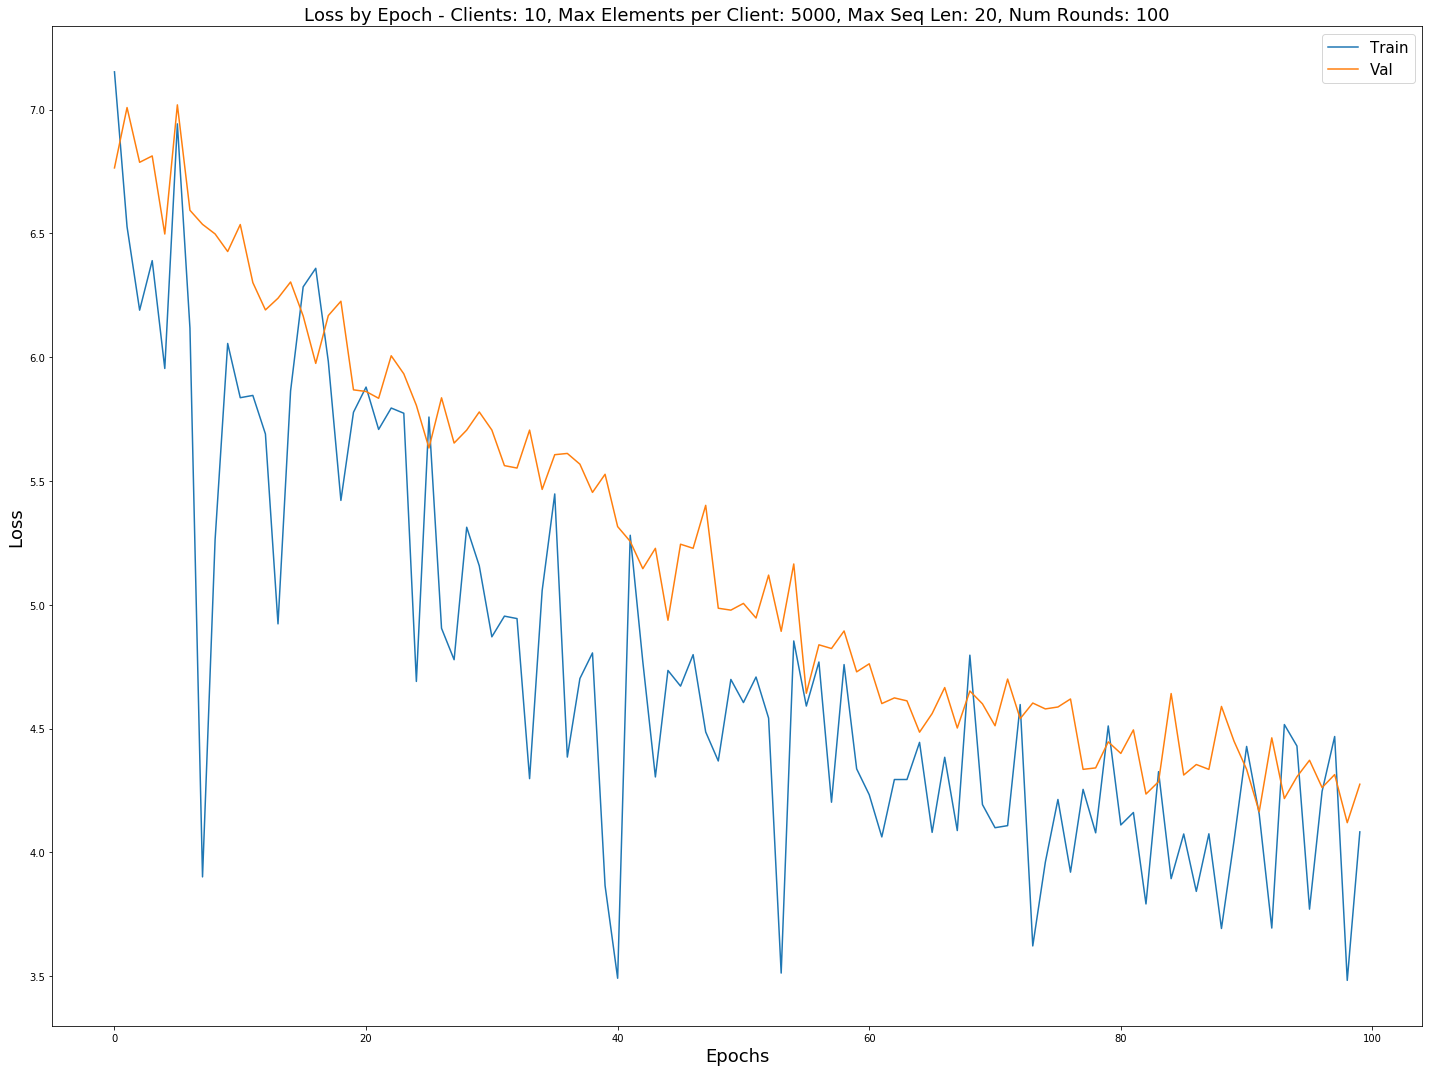

In [31]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
ax.legend(loc='best', prop={'size': 15})
plt.title('Loss by Epoch - {}'.format(round_config), fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.tight_layout()
plt.savefig(SAV + 'Loss by Epoch.png')
plt.show()

### Plot Train and Validation Accuracy

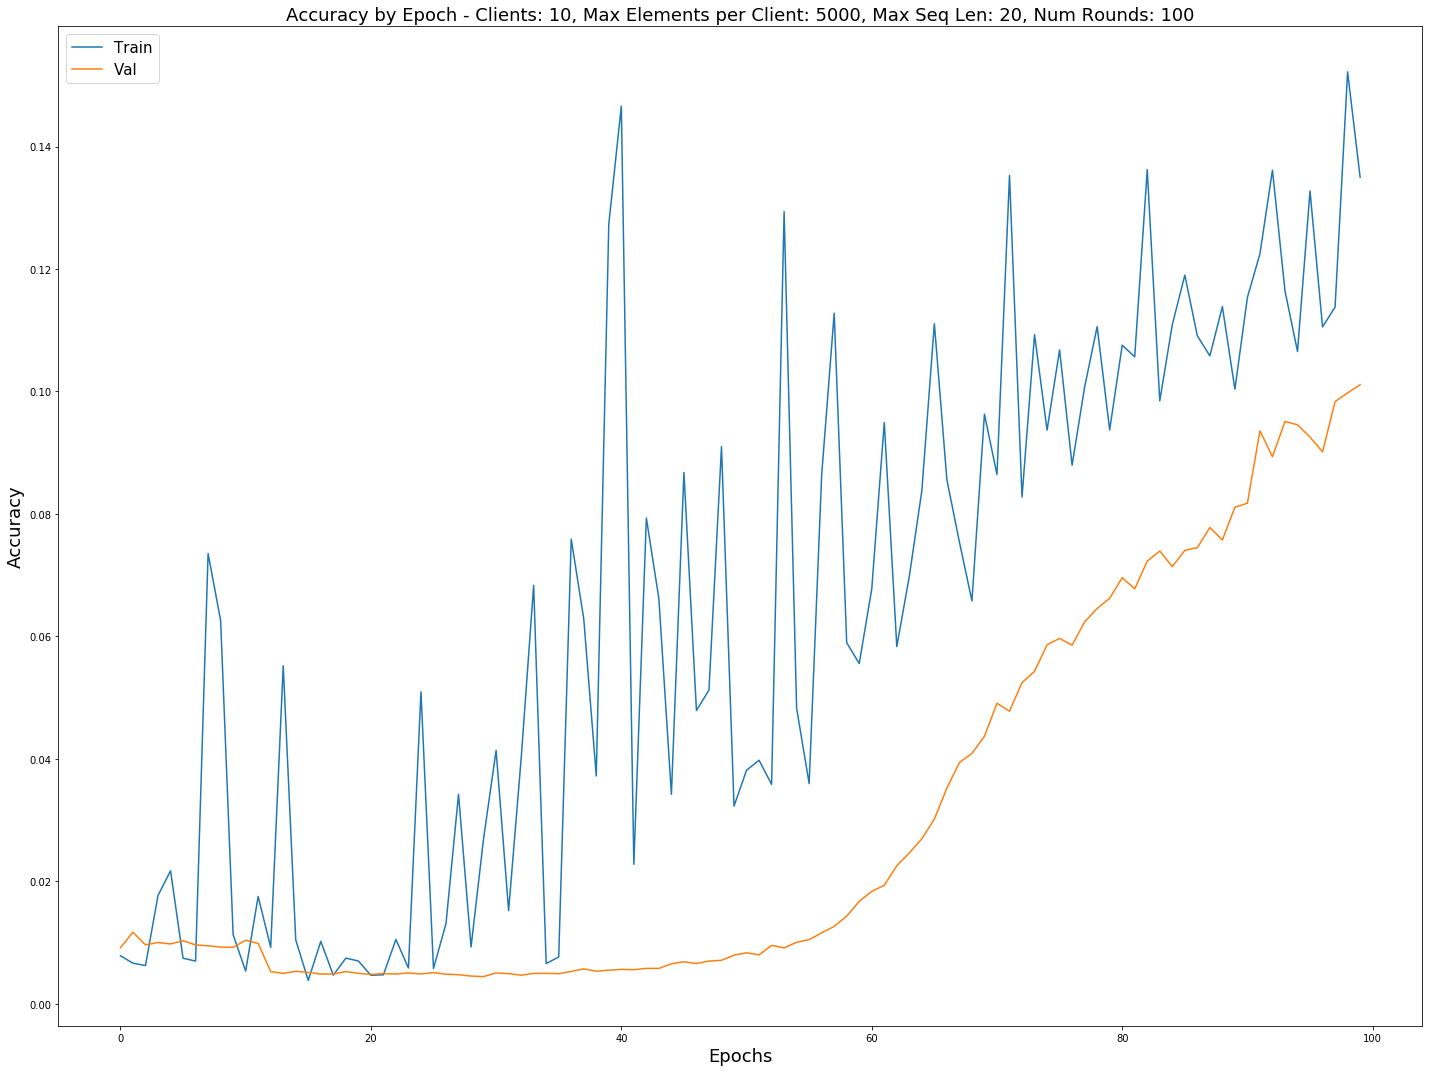

In [32]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
ax.legend(loc='best', prop={'size': 15})
plt.title('Accuracy by Epoch - {}'.format(round_config), fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.tight_layout()
plt.savefig(SAV + 'Accuracy by Epoch.png')
plt.show()